# LabWBFM: Wideband Frequency Modulation (WBFM)

Commercial FM broadcast band extends from **88MHz to 108MHz**, totaling 20MHz of spectrum. A slot of **200kHz** bandwidth is given to each station. Thus, there exist 100 stations at most. 200kHz bandwidth is huge when compared to NBFM where bandwidth is around 5kHz. There will be also more than one component in this bandwidth as we'll see. So, wideband term comes from these facts. 

### Example WBFM Walkthrough

Consider example record given in your repo, `rtl_wbfm.dat`. This file has been recorded using RTL-SDR set to **94.1MHz** at a rate of **2.048Msps**, ie 2048000 samples per second. 

In [1]:
import os
file_name = 'rtl_wbfm.dat'
number_of_samples = os.path.getsize(file_name) / 2
print("Record contains " + str(int(number_of_samples)) + " complex samples and this corresponds to " + str(number_of_samples / 2048000) + " seconds data. ")

Record contains 20480000 complex samples and this corresponds to 10.0 seconds data. 


We will use the same Python function to read IQ file recorded by RTL-SDR. 

In [2]:
def RTLSDRLoadRecord(file_name):
    import numpy as np
    data = np.fromfile(file_name, np.uint8)
    # change it to complex data
    data_c = data[::2] + 1j * data[1::2]
    # remove offset
    return data_c - (128 + 1j * 128)

Use this function to read first FM record. 

In [3]:
data = RTLSDRLoadRecord(file_name);

Spectrogram function displays frequency content versus time. 

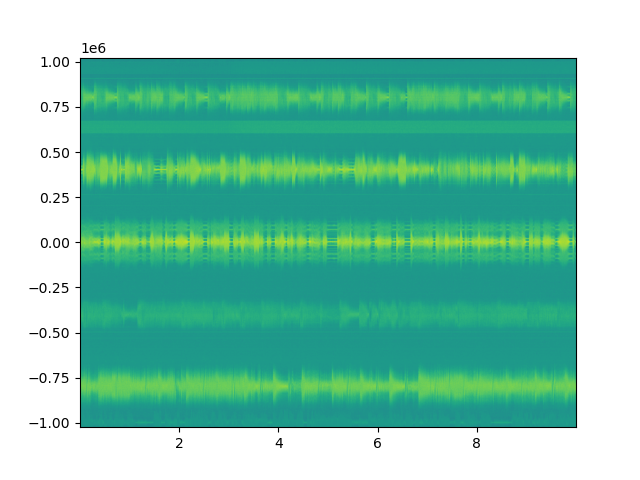

In [4]:
import matplotlib.pyplot as plt
%matplotlib widget
sp = plt.specgram(x=data, Fs=2048000, NFFT=2048)

Another good utility to see frequency content is to use **Power Spectral Density (PSD)** graph. 

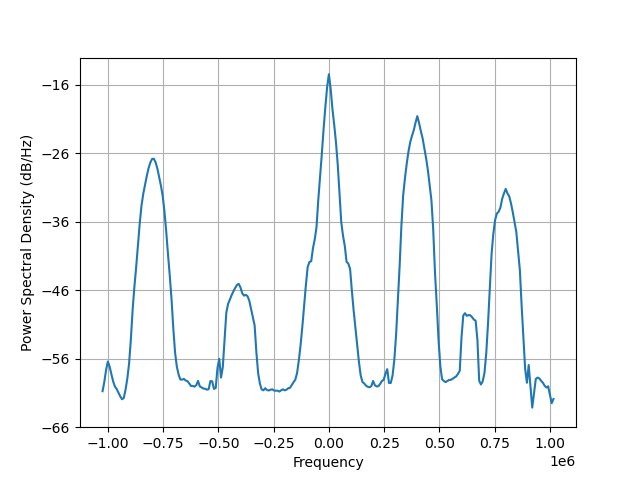

In [5]:
plt.figure()
psd = plt.psd(x=data, Fs=2048000)

## Decimate and plot
You will probably see more than one station. We will go with the **baseband** signal. Our sample rate is 2.048MHz, and signal bandwidth is 200kHz, therefore we can decimate signal by 8 and get rid of other stations in the spectrum. Remember our new sample rate will be 256k after decimation. 

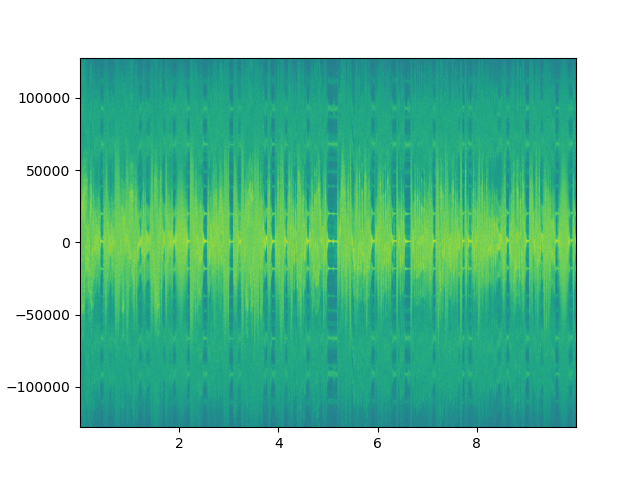

In [6]:
# Then decimate it by an amount to play it with our sound card. 
from scipy import signal
data_dec = signal.decimate(data, 8, ftype='fir')
plt.figure()
sp = plt.specgram(x=data_dec, Fs=256000, NFFT=2048)

## WBFM Demodulation
We will WBFM demodulate the signal using **limiter** followed by **discriminator**. 

First we use limiter to get rid of amplitude variations so that discriminator is only sensitive to frequency deviations. Avoid divide-by-zero by adding small amount to the magnitude. 

In [8]:
data_limit = data_dec / (abs(data_dec) + 1e-6)

Second, design an FIR differentiator. Plot its impulse response and frequency response. 

Text(0.5, 1.0, 'Magnitude frequency response of the differentiator filter')

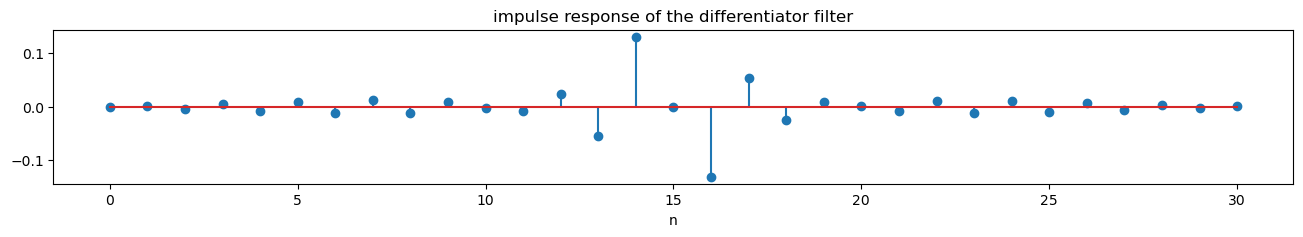

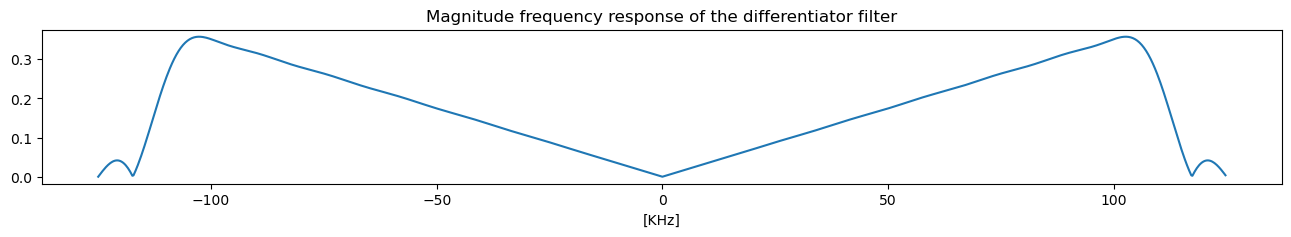

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 256000.0, type='differentiator')

H_diff = np.fft.fftshift(np.fft.fft(h_diff,n=1024))

w = np.r_[-512.0:512.0]/1024.0*250
fig=plt.figure(figsize=(16,2))
plt.stem(h_diff)
plt.xlabel('n')
plt.title('impulse response of the differentiator filter')

fig=plt.figure(figsize=(16,2))
plt.plot(w,abs(H_diff))
plt.xlabel('[KHz]')
plt.title('Magnitude frequency response of the differentiator filter')

In [10]:
%matplotlib inline
data_demod = (np.convolve(data_limit, h_diff, mode='same') * data_limit.conj()).imag

Decode mono signal

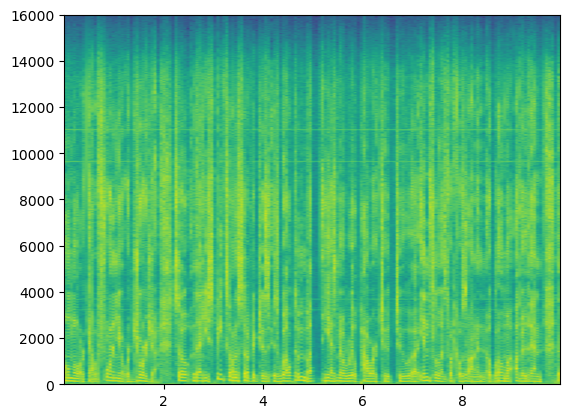

In [11]:
data_dec2 = signal.decimate(data_demod, 8)
plt.specgram(x=data_dec2, Fs=32000, NFFT=2048);

Play mono component

In [12]:
import sounddevice as sd
max_val=np.max(data_dec2)
sd.play(data_dec2/max_val, 32000);

# Task-1

## Q1: Write a complete WBFM decoder function for RTL-SDR record (10pts)

Package up what we have done so far to demodulate WBFM signal into a Python function, named `wbfm_decoder.m`. You would invoke it as shown below. **It will take two params, record file name and frequency shift and will return 48kHz WBFM mono component**. 
```
sound(wbfm_decoder('rtl_wbfm.dat', 0), 48000)
```

## A1: Define your function in the below cell. 

## Q2: Test your function (10pts)
Use your `wbfm_decoder` function to test it. Demodulate baseband channel i.e., 0 Hz and save mono channel sound as `wbfm_mono.wav`. Remember that this band is commercial FM band! 

## A2: Wav record for baseband station's mono channel

## Q3: Inspect baseband channel's demodulated data (30pts)
Now carefully inspect baseband channel's demodulated data. Be careful not mono channel data! There are hidden signals inside. At which frequencies do you spot activities? 

## A3: Hidden signals: 

## Q4: List other stations (20pts)
Example record contains other FM stations. Spot these stations and write them the cell below. Write both relative and real RF frequencies. 

## A4: Other stations are: 

## Q5: Test your function on other stations (20pts)
Use your `wbfm_decoder` function to test it. Create wav files named `other[n].wav` where n is other station number (1-4). 

# Task 2
Implement the following flowgraph to receive and demodulate only one FM station. 
<center><img src="./lab_wbfm_single_channel.png" alt="rtl-sdr" style="width: 1200px;"/></center>
<center>Figure 1: Single channel reception </center>

# Task 3
Implement the following flowgraph to receive two FM stations together. 
<center><img src="./lab_wbfm_multi_channel.png" alt="rtl-sdr" style="width: 1200px;"/></center>
<center>Figure 1: Multi channel reception </center>

## Q1: What happens when you play with the slider?